# (Amortized) distance learning directly using a feedforward network
- define prior $p(\theta)$ and sample
- produce simulations $x \sim p(x|\theta)$
- append observations $x_o$
- compute $d(\theta_i, x_j) := d(x(\theta_i),x_j), x_j \in \{X_{simulated}, X_{observed}\}$
- train network $NN_{\phi}(\theta_i, x_j) \rightarrow d(x(\theta_i),x_j)$
- at inference time, define generalized likelihood $e^{-\beta \times NN_{\phi}(\theta, x_o)}$, and sample GBI posterior

In [571]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [572]:
import matplotlib.pyplot as plt
import torch
from torch import zeros, ones, nn, Tensor, optim
from torch.utils.data import TensorDataset, DataLoader
from sbi.utils.torchutils import atleast_2d

from sbi.utils import BoxUniform, likelihood_nn
from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
from sbi.inference import MCMCPosterior, SNPE, DirectPosterior #SNLE, RejectionPosterior, likelihood_estimator_based_potential

import numpy as np
import sbibm

In [ ]:
class DistanceRegressionEstimator(nn.Module):
    def __init__(self, theta_dim, x_dim, hidden_features, num_layers):
        super().__init__()
        # self.beta_sampling = 1

        input_dim = theta_dim + x_dim
        output_dim = 1

        layers = [nn.Linear(input_dim, hidden_features), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(hidden_features, output_dim))
        self.net = nn.Sequential(*layers)
        
    def forward(self, theta, x):
        """
        Predicts distance between theta and x
        """        
        return self.net(torch.concat((theta, x), dim=-1))

    
def build_amortized_GLL(
    distance_net: nn.Module,
    x_o: Tensor,
):
    def generalized_loglikelihood(thetas: Tensor):
        thetas = atleast_2d(thetas)
        # print('here')
        # print(x_o, thetas.shape)
        distances = distance_net(thetas, x_o.repeat((thetas.shape[0],1))).squeeze(1)
        # print(distances.shape, (thetas.shape[0],))
        assert distances.shape == (thetas.shape[0],)
        return distances

    return generalized_loglikelihood

In [5]:
prior = BoxUniform(-ones(2), ones(2))
def simulator(theta):
    return theta ** 2 + torch.randn(theta.shape) * 0.1

In [175]:
_ = torch.manual_seed(0)

# simulate
theta = prior.sample((500,))
x = simulator(theta)

# make "observations"
theta_obs = prior.sample((20,))
x_obs = simulator(theta_obs)

# make some misspecified examples
x_obs[10:] -= torch.randn(x_obs[10:].shape)
xs = torch.concat((x, x_obs), 0)

# compute distances
dists_precomp = torch.vstack([mse_dist(x.unsqueeze(1), x_i) for x_i in xs]).T
idx_train = Tensor(np.indices((theta.shape[0],xs.shape[0])).reshape((2,-1)).T).to(int)

In [204]:
batch_size = 500
n_epochs = 10

dataset = TensorDataset(idx_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
distance_net = DistanceRegressionEstimator(theta.shape[1], x.shape[1], 64, 3)

nn_loss = nn.MSELoss()
optimizer = optim.Adam(distance_net.parameters())

losses = []
for e in range(n_epochs):
    for idx_batch in dataloader:
        optimizer.zero_grad()
        
        # load up the thetas, xs, and distances
        theta_batch, xs_batch = theta[idx_batch[0][:,0]], xs[idx_batch[0][:,1]]
        
        # look up from precomputed distance matrix
        dist_batch = dists_precomp[idx_batch[0][:,0], idx_batch[0][:,1]]
        
        # ... or compute on the spot
        
        
        # forward pass for distances
        dist_pred = distance_net(theta_batch, xs_batch).squeeze()
        

        l = nn_loss(dist_batch, dist_pred)
        l.backward()
        optimizer.step()        
        losses.append(l.detach())
    
    if e%100==0:
        print(f"{e}: {l}")

0: 0.004612804390490055


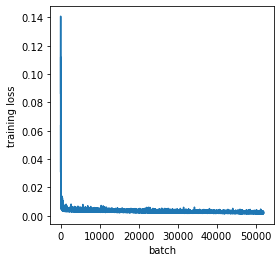

In [208]:
plt.figure(figsize=(4,4))
plt.plot(losses)
plt.xlabel('batch'); plt.ylabel('training loss');

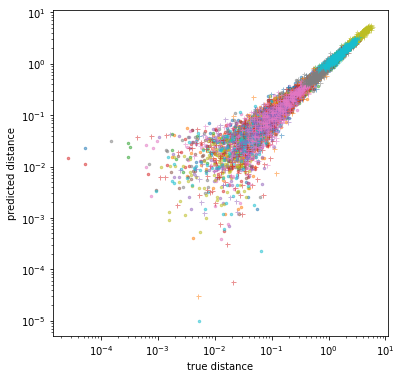

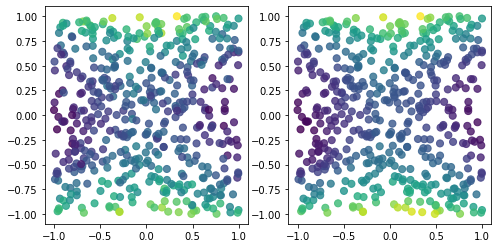

In [419]:
plt.figure(figsize=(6,6))
# x_o = x_obs[12,:]
for i_x, x_o in enumerate(x_obs):
    dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
    dist_true = mse_dist(x.unsqueeze(1), x_o)
    plt.loglog(dist_true, dist_pred.detach(), '.' if i_x<10 else '+', ms=5, alpha=0.5)
    
plt.xlabel('true distance'); plt.ylabel('predicted distance');

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.8)
plt.subplot(1,2,2)
plt.scatter(theta[:,0], theta[:,1], c=dist_pred.detach(), s=50, alpha=0.8)

In [421]:
i_o = 1
x_o = x_obs[i_o]
theta_o = theta_obs[i_o]
dist_true = mse_dist(x.unsqueeze(1), x_o)

gll = build_amortized_GLL(distance_net, x_o)
gbi_potential = GBIPotential(prior, gll, beta=20.)
gbi_potential.set_x(x_o)
sampler = MCMCPosterior(gbi_potential, prior)

In [422]:
theta_posterior_samples = sampler.sample((100,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

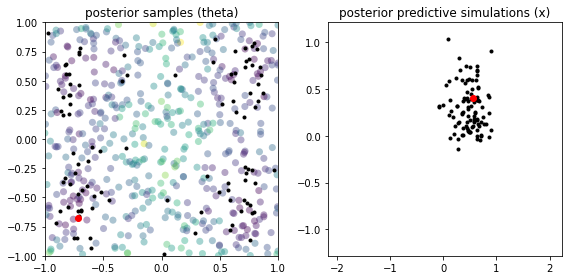

In [425]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(theta_np[:,0], theta_np[:,1], '.k')
plt.plot(theta_o[0],theta_o[1], 'or')
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.4, ec=None)
plt.xlim([-1,1]);plt.ylim([-1,1]);
plt.title('posterior samples (theta)')

plt.subplot(1,2,2)
x_pp = simulator(theta_posterior_samples)
plt.plot(x_pp[:,0], x_pp[:,1], 'k.')
plt.plot(x_o[0], x_o[1], 'ro')
plt.xlim(xs[:,0].min(), xs[:,0].max())
plt.ylim(xs[:,1].min(), xs[:,1].max())
plt.title('posterior predictive simulations (x)')
plt.tight_layout()

---
# 2-moons

In [428]:
def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, (d1_res)*(d2_res))).T
    dx = torch.diff(x1).mean()*torch.diff(x2).mean()
    return xs, dx

In [510]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
simulator = task.get_simulator()
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)

x_grid, dx = make_2d_grid((-1.5,1.5), (-1.5, 1.5), 200,200)
th_res = (100, 100)
theta_grid, dth = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


In [511]:
_ = torch.manual_seed(0)

# simulate
theta = prior(5000,)
x = simulator(theta)

# make "observations"
theta_obs = prior(20,)
x_obs = simulator(theta_obs)

# make some misspecified examples
x_obs[10:] -= 0.5 #torch.randn(x_obs[10:].shape)
xs = torch.concat((x, x_obs), 0)

# compute distances
dists_precomp = torch.vstack([mse_dist(x.unsqueeze(1), x_i) for x_i in xs]).T
idx_train = Tensor(np.indices((theta.shape[0],xs.shape[0])).reshape((2,-1)).T).to(int)

In [ ]:
batch_size = 100
n_epochs = 20

dataset = TensorDataset(idx_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
distance_net = DistanceRegressionEstimator(theta.shape[1], x.shape[1], 64, 3)

nn_loss = nn.MSELoss()
optimizer = optim.Adam(distance_net.parameters())

losses = []
for e in range(n_epochs):
    for idx_batch in dataloader:
        optimizer.zero_grad()
        
        # load up the thetas, xs, and distances
        theta_batch, xs_batch = theta[idx_batch[0][:,0]], xs[idx_batch[0][:,1]]
        
        # look up from precomputed distance matrix
        dist_batch = dists_precomp[idx_batch[0][:,0], idx_batch[0][:,1]]
        
        # ... or compute on the spot
            
        # forward pass for distances
        dist_pred = distance_net(theta_batch, xs_batch).squeeze()
        

        l = nn_loss(dist_batch, dist_pred)
        l.backward()
        optimizer.step()        
        losses.append(l.detach())
    
    if e%1==0:
        print(f"{e}: {l}")

0: 0.0033566344063729048
1: 0.0044172839261591434
2: 0.004380556754767895
3: 0.004244915675371885
4: 0.0030074843671172857
5: 0.0034854754339903593


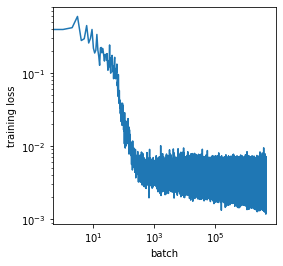

In [513]:
plt.figure(figsize=(4,4))
plt.loglog(losses)
plt.xlabel('batch'); plt.ylabel('training loss');

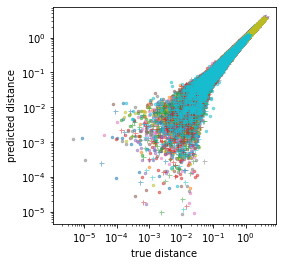

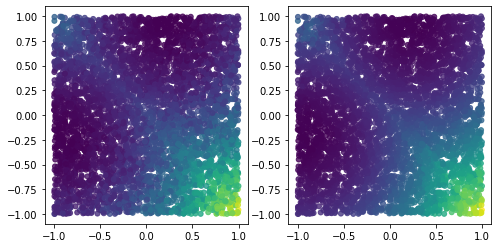

In [518]:
MS = 25
plt.figure(figsize=(4,4))

for i_x, x_o in enumerate(x_obs):
    dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
    dist_true = mse_dist(x.unsqueeze(1), x_o)
    plt.loglog(dist_true, dist_pred.detach(), '.' if i_x<10 else '+', ms=5, alpha=0.5)
    
plt.xlabel('true distance'); plt.ylabel('predicted distance');

x_o = x_obs[1,:]
dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
dist_true = mse_dist(x.unsqueeze(1), x_o)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=MS, alpha=0.8)
plt.subplot(1,2,2)
plt.scatter(theta[:,0], theta[:,1], c=dist_pred.detach(), s=MS, alpha=0.8)

In [573]:
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))

# train NPE for comparison
inference = SNPE(prior, 'nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 91 epochs.

In [565]:
# sample with GBI potential
i_o = 14
x_o = x_obs[i_o]
theta_o = theta_obs[i_o]
dist_true = mse_dist(x.unsqueeze(1), x_o)

In [566]:
gll = build_amortized_GLL(distance_net, x_o)
gbi_potential = GBIPotential(prior, gll, beta=200.)
gbi_potential.set_x(x_o)
sampler = MCMCPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((100,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

In [570]:
npe_samples = posterior.sample((100,), x=x_o).numpy()

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 100 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


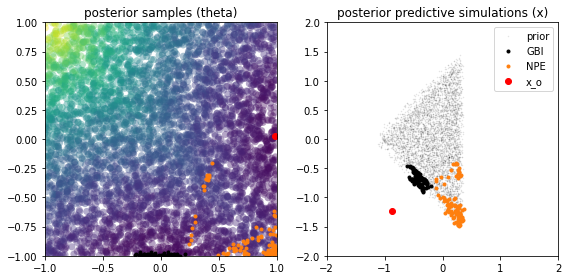

In [568]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(theta_np[:,0], theta_np[:,1], '.k')
plt.plot(npe_samples[:,0], npe_samples[:,1], '.C1')
plt.plot(theta_o[0],theta_o[1], 'or')
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.4, ec=None)
plt.xlim([-1,1]);plt.ylim([-1,1]);
plt.title('posterior samples (theta)')

plt.subplot(1,2,2)
x_pp = simulator(theta_posterior_samples)
x_npe = simulator(npe_samples)

plt.plot(x[:,0],x[:,1], '.k', alpha=0.1, ms=1, label='prior')
plt.plot(x_pp[:,0], x_pp[:,1], 'k.', label='GBI')
plt.plot(x_npe[:,0], x_npe[:,1], 'C1.', label='NPE')
plt.plot(x_o[0], x_o[1], 'ro', label='x_o')
plt.legend()
plt.xlim([-2,2]);plt.ylim([-2,2]);
# plt.xlim(xs[:,0].min(), xs[:,0].max())
# plt.ylim(xs[:,1].min(), xs[:,1].max())
plt.title('posterior predictive simulations (x)')
plt.tight_layout()

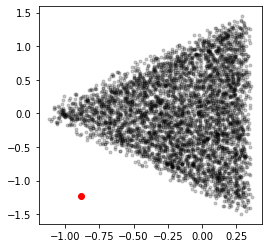

In [547]:
i_o = 14
x_o = x_obs[i_o]
plt.figure(figsize=(4,4))
plt.plot(x_o[0], x_o[1], 'ro')
plt.plot(x[:,0],x[:,1], '.k', alpha=0.2)